In [157]:
%matplotlib inline

In [101]:
import numpy as np
from math import *
from pylab import *
import random
import tensorflow as tf

In [124]:
tf.reset_default_graph()
sess = tf.Session()

In [241]:
batch_size = 128
num_iterations = 100001

In [153]:
def load_item_feature(LOAD_PATH):
    D = {}
    for i in range(25):
        print i
        x = np.load(LOAD_PATH % (i))
        for key, val in x:
            if key not in D:
                D[key] = []
            D[key] += [val]
    return D

app_features = load_item_feature("tmp_app_install/feature-%d.npy")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [ ]:
url_features = load_item_feature("tmp_url/feature-%d.npy")

0


In [7]:
# get labels
from random import shuffle

def read_user_labels():
    user_labels = {}

    for fn in ['contest_dataset_label/label000000_0', 'contest_dataset_label/label000001_0']:
        with open(fn) as file_user_label:
            for x in file_user_label:
                user_id, gender, user_age = x.split()
                user_labels[user_id] = [int(gender) - 1, int(user_age) - 1]

    return user_labels

user_labels = read_user_labels()
print len(user_labels)

11439408


In [165]:
def load_good_maps(good_path):
    '''
        Save/load good apps from file
    '''
    good_urls = np.load(good_path).item()
    good_gender_urls = good_urls['gender']
    good_age_urls = good_urls['age']

#     good_age = {}
#     good_gender = {}
#     for i, url_id in good_gender_urls:
#         good_gender[url_id] = i # , freq_gender[url_id][0]
#     for i, app_id in good_age_urls:
#         good_age[url_id] = i #, freq_age[url_id][1]

    return good_gender_urls, good_age_urls

gender_url, age_url = load_good_maps("tmp_url/good_urls.npy")
gender_app, age_app = load_good_maps("tmp_app_install/good_apps.npy")
# for i in range(REG_DIM):
#     print good_gender_urls[i], np.sum(freq_gender[good_gender_urls[i][1]]), good_age_urls[i], np.sum(freq_age[good_age_urls[i][1]])

# figure()
# hist([x for x, y in gender_dists if x > 0.2], bins=40)
# show()
# print gender_dists[100]
# print age_dists[100]
# print log(7) / log(2) * 0.14591690295265844

In [ ]:
'''
define model
'''
class Model:
    def __init__(self, sess, idim, odim, keep_rate):
        self.op_X = tf.placeholder(np.float32, [None, idim])
        self.op_Y = tf.placeholder(np.int32, [None])
        h1 = tf.contrib.layers.fully_connected(
            inputs=tf.nn.dropout(self.op_X, keep_rate),
            num_outputs=200,
            activation_fn=tf.nn.relu,
#             biases_initializer=tf.random_normal_initializer()
        )
        h2 = tf.contrib.layers.fully_connected(
            inputs=tf.nn.dropout(h1, keep_rate),
            num_outputs=odim,
#             activation_fn=tf.nn.relu,
#             biases_initializer=tf.random_normal_initializer()
        )
#         h3 = tf.contrib.layers.fully_connected(
#             inputs=tf.nn.dropout(h2, keep_rate),
#             num_outputs=odim,
# #             activation_fn=tf.nn.relu,
#             biases_initializer=tf.random_normal_initializer()
#         )
        self.logits = h2
        
#         regularization = tf.contrib.layers.apply_regularization(tf.contrib.layers.l1_regularizer(lambda_1)) + \
#             tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(lambda_2))
#         regularization = 0
        self.op_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(self.logits, self.op_Y))
        
        optimizer = tf.train.AdamOptimizer()
        self.op_train = optimizer.minimize(self.op_loss) # no regularization due to dropout
        self.op_output = tf.nn.softmax(self.logits)
        
        sess.run(tf.initialize_all_variables())
    
    def train(self, sess, X, Y, loss=False):
        ops = [self.op_train, self.op_loss, self.logits]
        ans = sess.run(
            ops,
            feed_dict={
                self.op_X: X,
                self.op_Y: Y,
            }
        )
        return ans[1:]
    
    def predict(self, sess, X):
        return sess.run(
            self.op_output,
            feed_dict={
                self.op_X: X
            }
        )

model_gender = Model(sess, 2000, 2, 0.9)
model_age = Model(sess, 2000, 7, 0.9)
losses = []

In [197]:
def get_features(user_id):
    X = np.zeros(2000, np.float32)
    Y = None
    if user_id in user_labels:
        Y = user_labels[user_id]
    if user_id in url_features:
        for url_id in url_features[user_id]:
            url_id = int(url_id)
            if url_id in gender_url:
                url_num = gender_url[url_id]
                X[url_num] = 1.
    if user_id in app_features:
        for app_id in app_features[user_id]:
            if app_id in gender_app:
                app_num = gender_app[app_id]
                X[app_num + 1000] = 1.
    return X, Y

In [ ]:
'''
train
'''

ids = []
user_ids = user_labels.keys()
for T in xrange(num_iterations):
    X = np.zeros((batch_size, 2000), dtype=np.float32)
    Y_g = np.zeros((batch_size), dtype=np.int32)
    Y_a = np.zeros((batch_size), dtype=np.int32)
    
    tried, used = 0, 0
    
    for i in xrange(batch_size):
        while True:
            tried += 1
            user_id = random.sample(user_ids, 1)[0]
            x, (gender, age) = get_features(user_id)
            if np.sum(x) > 0:
                used += 1
                ids += [user_id]
                X[i] = x
                Y_g[i] = gender
                Y_a[i] = age
                break

    has_loss = T % 100 == 0
#     pred_gender = model_gender.predict(sess, X)
    loss_gender = model_gender.train(sess, X, Y_g, has_loss)
    loss_age = model_age.train(sess, X, Y_a, has_loss)
    if has_loss:
        print "#%d: tried/used = %d/%d, loss(gender = %.6f, age = %.6f)" % (T, tried, used, loss_gender[0], loss_age[0])
        
#         print loss_gender[0]
# #         print loss_gender[1]
#         x = loss_gender[1]
#         x = np.exp(x - np.max(x))
#         x = x / np.sum(x, axis=1, keepdims=True)
#         print x
#         print pred_gender
#         l = 0.
#         for i in range(batch_size):
#             l -= log(x[i][Y_g[i]])
#         print l / batch_size, sum(Y_g)
# #         print Y_g
#         break

#0: tried/used = 179/128, loss(gender = 0.691953, age = 1.957310)
#100: tried/used = 185/128, loss(gender = 0.490490, age = 1.767708)


In [95]:
freq_gender = np.zeros((300, 2))
for user_id, urls in url_features.iteritems():
    for url_id in urls:
        url_id = int(url_id)
        if url_id in good_gender:
            url_num = good_gender[url_id]
            if user_id in user_labels:
                freq_gender[url_num][user_labels[user_id][0]] += 1

In [21]:
freq_gender

array([[   8617.,   84329.],
       [  17543.,  105807.],
       [   1607.,    9248.],
       [   2123.,    9690.],
       [   8761.,   31088.],
       [   4438.,   15462.],
       [   2884.,   10038.],
       [   4131.,   13996.],
       [   2410.,    7831.],
       [   2802.,    9068.],
       [   3278.,   10570.],
       [   3818.,   12108.],
       [   4894.,   15433.],
       [   6076.,   19101.],
       [   2949.,    8882.],
       [   3812.,   11281.],
       [  13966.,   40910.],
       [   2861.,    8379.],
       [   2997.,    8769.],
       [   6278.,   18164.],
       [   2819.,    7917.],
       [   4203.,   11774.],
       [   3750.,   10508.],
       [   4842.,   13471.],
       [   7645.,   20943.],
       [   4435.,   12152.],
       [   3204.,    8747.],
       [  10373.,   28135.],
       [   3381.,    8996.],
       [   6355.,   16571.],
       [   3570.,    9148.],
       [   7118.,   17646.],
       [   3777.,    9214.],
       [   5630.,   13548.],
       [   555

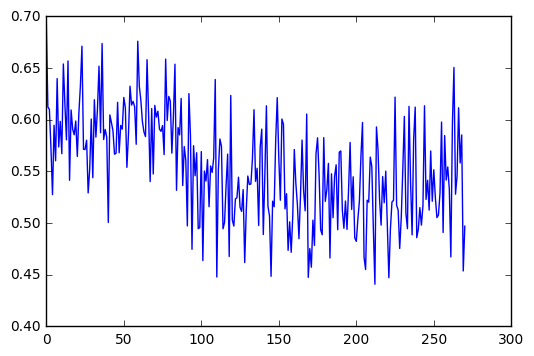

In [119]:
figure()
plot(range(len(losses)), losses)
show()

In [231]:
'''
The function which tries to predict a user.
'''

def predict(batch):
#     cur_gender, cur_age = np.zeros(2), np.zeros(7) # all_gender / sum(all_gender), all_age / sum(all_age)
    n = len(batch)
    X = np.zeros((n, 2000))
    
    for i, user_id in enumerate(batch):
        x, _ = get_features(user_id)
        X[i] = x
    cur_gender = model_gender.predict(sess, X)
    cur_age = model_age.predict(sess, X)
    for i in range(n):
        if sum(X[i]) == 0:
            cur_gender[i] = all_gender
            cur_age[i] = all_age
    return cur_gender, cur_age


In [142]:
# load testset data

testset = []
with open('contest_testset/testset000000_0') as file_test:
    for x in file_test.readlines():
        testset += [x[:-1]]

freqs = np.load("all_dist.npy").item()
all_gender = freqs['gender']
all_age = freqs['age']
 

In [237]:
'''
write a new CSV.
'''

D = []
xxx = 0

def test(predict, filename):
    with open(filename, 'w') as fout:
        print >> fout, 'user_id,gender_1,gender_2,age_g1,age_g2,age_g3,age_g4,age_5,age_g6,age_7'
        cnt = 0
        B = 128
        for b in range((len(testset) + B - 1) // (B)):
            current_batch = testset[b * B:(b + 1) * B]

            pred_gender, pred_age = predict(current_batch)
            for i, user_id in enumerate(current_batch):
                cnt += 1
                if cnt % 10000 == 0:
                    print cnt
            
                cur_gender, cur_age = pred_gender[i], pred_age[i]

                print >> fout, '%s,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f' % (user_id, cur_gender[0], cur_gender[1], cur_age[0], cur_age[1], cur_age[2], cur_age[3], cur_age[4], cur_age[5], cur_age[6])

test(predict, 'CloudPlatform_0921_1.csv')

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000


In [264]:
'''
Cross validation on devset.
'''

def cross_validate(devset):
    loss_age, loss_gender = 0., 0.
    
    cnt = 0
    
    B = 128
    for b in range((len(devset) + B - 1) // (B)):
        current_batch = devset[b * B:(b + 1) * B]
        
        pred_gender, pred_age = predict(current_batch)
        for i, user_id in enumerate(current_batch):
            cnt += 1
            gender, age = user_labels[user_id]
            loss_age -= log(pred_age[i][age])
            loss_gender -= log(pred_gender[i][gender])
            if cnt % 1000 == 0:
                print cnt

    loss_age /= len(devset)
    loss_gender /= len(devset)

    print 'loss: gender = %.6f, age = %.6f, overall = %.6f' % (loss_gender, loss_age, (loss_age + loss_gender) / 2)

devset = random.sample(user_labels.keys(), 100000)
cross_validate(devset)

ValueError: could not broadcast input array from shape (2) into shape (200)

In [177]:
useful = 0
for i, user_id in enumerate(user_labels.iterkeys()):
    if np.sum(get_features(user_id)[0][1000:]) != 0:
        useful += 1
    if i % 10000 == 0:
        print i, useful

0 1
10000 6211
20000 12492
30000 18802
40000 25123
50000 31316
60000 37546
70000 43877
80000 50180
90000 56463
100000 62755


KeyboardInterrupt: 

In [150]:
user_labels.keys()[:10]

['3ecdc76fa6fa5fb6286f99c505909427',
 '2dfb68cda5855e085595a096a59c8e25',
 'b49a28db511b54d20e847f792b994f34',
 'c506cc4659900717eb51208606ab6174',
 'a1c7fc6042ab5364eca1e78c40b78658',
 '9e0acfe44af5e373b2756cfcc7e526a5',
 '5682e41be84ffd1a728357706a71fda3',
 '67d23d4e92663c4594003d6dd5fd020e',
 'b900cffe07789bebe8e8b8efc2b4aecf',
 'b78ef6a72804c0652484fc68890f593b']

In [161]:
app_features["3ecdc76fa6fa5fb6286f99c505909427"]

['44537e9bd936253cce232bde74ed4e84',
 'c088c93bad9b04fc3248ddbdf67cad6e',
 'f8193c9424248872c03deb7cc735a645',
 '39f6d15e01b219817bd48285523b12cf']

In [226]:
len(ids)

128128